# Lesson 5: Resolution Limits
This is a guided tutorial designed to illustrate the what a resolution limit in the context of community detection is and illustrates some of the ways we can use to solve the resolution limit 

## Chapter 0:Launching the GUI
As always, we start by starting the GUI with the following command and navigating to the URL. You can go back to Lesson 1: GUI Installation for help with launching the GUI if you need a refresher.
```console
$ docker compose up
```
You should see an output like below.
```
[+] Running 2/2
 ✔ Container gui-cm-frontend-1  Created                                                                                                                                          0.0s
 ✔ Container gui-cm-backend-1   Created                                                                                                                                          0.0s
Attaching to backend-1, frontend-1
backend-1   | INFO:     Will watch for changes in these directories: ['/app/api']
backend-1   | INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
backend-1   | INFO:     Started reloader process [17] using StatReload
frontend-1  |
frontend-1  | Collecting usage statistics. To deactivate, set browser.gatherUsageStats to false.
frontend-1  |
frontend-1  |
frontend-1  |   You can now view your Streamlit app in your browser.
frontend-1  |
frontend-1  |   URL: http://0.0.0.0:8501
frontend-1  |
backend-1   | INFO:     Started server process [19]
backend-1   | INFO:     Waiting for application startup.
backend-1   | INFO:     Application startup complete.
```

Once you can see the GUI in your web browser like below, you've successfully connected to the GUI!

<img src="imgs/gui.png" width="800">

## Chapter 1: Clustering the ring-of-cliques network
A ring-of-cliques network is a graph formed by creating multiple cliques of the same size and arranging them in a ring such that each clique is connected to two other cliques. We can visualize an example of these networks with the graph provided in the data directory.


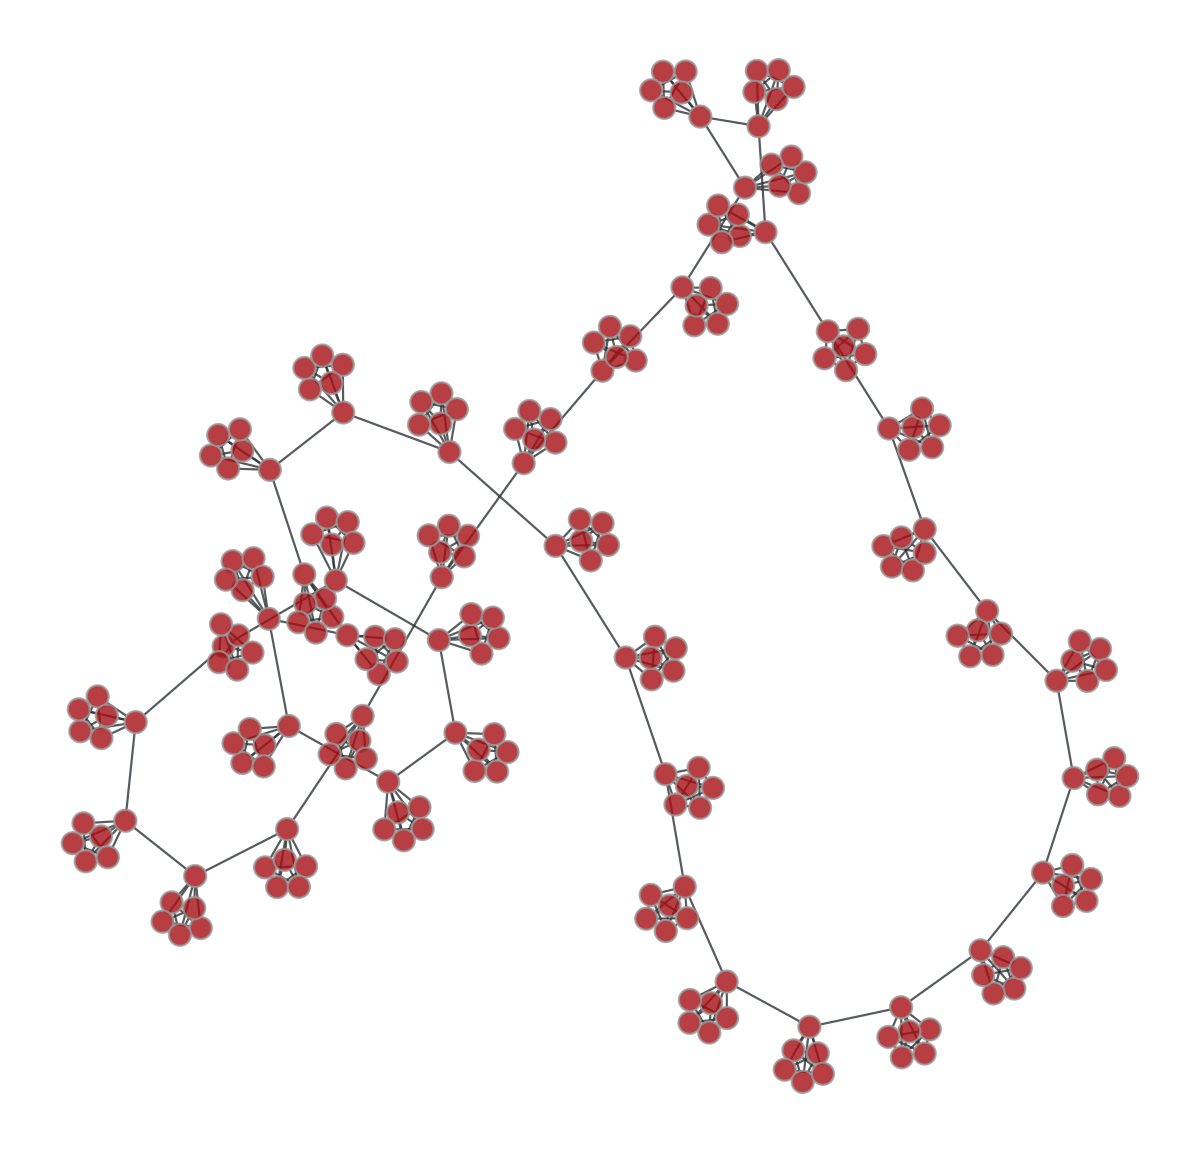

In [1]:
import graph_tool.all as gt
graph = gt.Graph(directed=False)
def edge_list_iterable():
    with open("./data/n_40_k_6.tsv", "r") as f:
        for line in f:
            u,v = line.strip().split()
            yield u,v
vpm_name = graph.add_edge_list(edge_list_iterable(), hashed=True, hash_type="string")
pos = gt.graph_draw(graph)

As you can see, this is a graph with 6 vertices in each clique, and there are 40 of them connecting in a ring, albeit it's not obvious at first that it's a ring.

We can upload this network file to the GUI and get a Leiden-CPM clustering with the following parameters.

<img src="imgs/options.png" width="300">

Once you've clustered the network and downloaded the clustering, let's try to visualize it by coloring each cluster with a unique color. We're picking random colors so everytime, the clusters will be the same but the colors will be different.

In [11]:
import ipywidgets as widgets
leiden_cpm_0_001_clustering = widgets.FileUpload(accept='', multiple=False)
leiden_cpm_0_001_clustering

FileUpload(value=(), description='Upload')

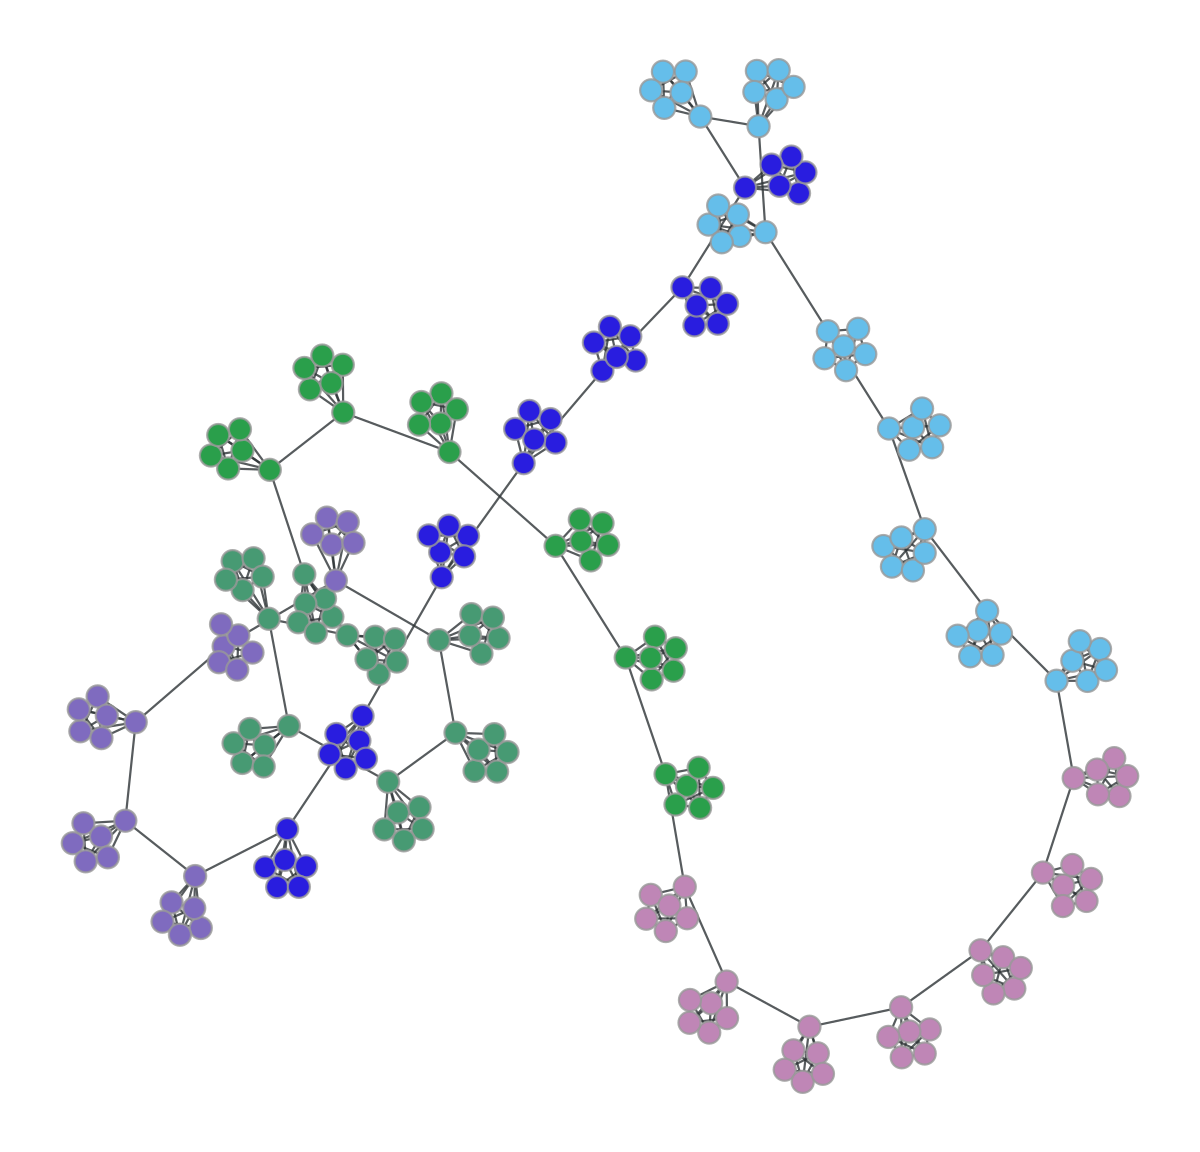

In [47]:
import random
old_to_new_id = {}
for vertex in graph.vertices():
    old_to_new_id[vpm_name[vertex]] = vertex
vertex_color_map = graph.new_vp("string")
for vertex in graph.vertices():
    vertex_color_map[vertex] = "#808080"
cluster_id_to_color_dict = {}
for line in leiden_cpm_0_001_clustering.value[0].content.tobytes().decode("utf-8").strip().split("\n"):
    node_id,cluster_id = line.strip().split()
    if cluster_id not in cluster_id_to_color_dict:
        cluster_id_to_color_dict[cluster_id] = f"#{random.randint(0, 0xFFFFFF):06x}"
    vertex_color_map[old_to_new_id[node_id]] = cluster_id_to_color_dict[cluster_id]
new_pos = gt.graph_draw(graph, pos=pos, vertex_fill_color=vertex_color_map)

You may notice that many of the adjacent cliques are labelled the same color, meaning that the clustering algorithm we used (Leiden-CPM with resolution value 0.001) have put these cliques together into a single cluster. This may seem unintuitive at first.

## Chapter 2: Solving the problem of adjacent cliques
Now, let's go back to the GUI but this time upload the clustering we just downloaded back to the GUI under the existing clustering option. It should look like the image below.

<img src="imgs/existing_clustering.png" width="300">

Additionally, we will use the WCC post treatment option like shown below. This will run the WCC (well-connected clusters) algorithm on the clustering we uploaded.

<img src="imgs/wcc.png" width="300">

Just like before, download the resulting clustering and upload it to the notebook once it's completed.

In [49]:
leiden_cpm_0_001_clustering_wcc = widgets.FileUpload(accept='', multiple=False)
leiden_cpm_0_001_clustering_wcc

FileUpload(value=(), description='Upload')

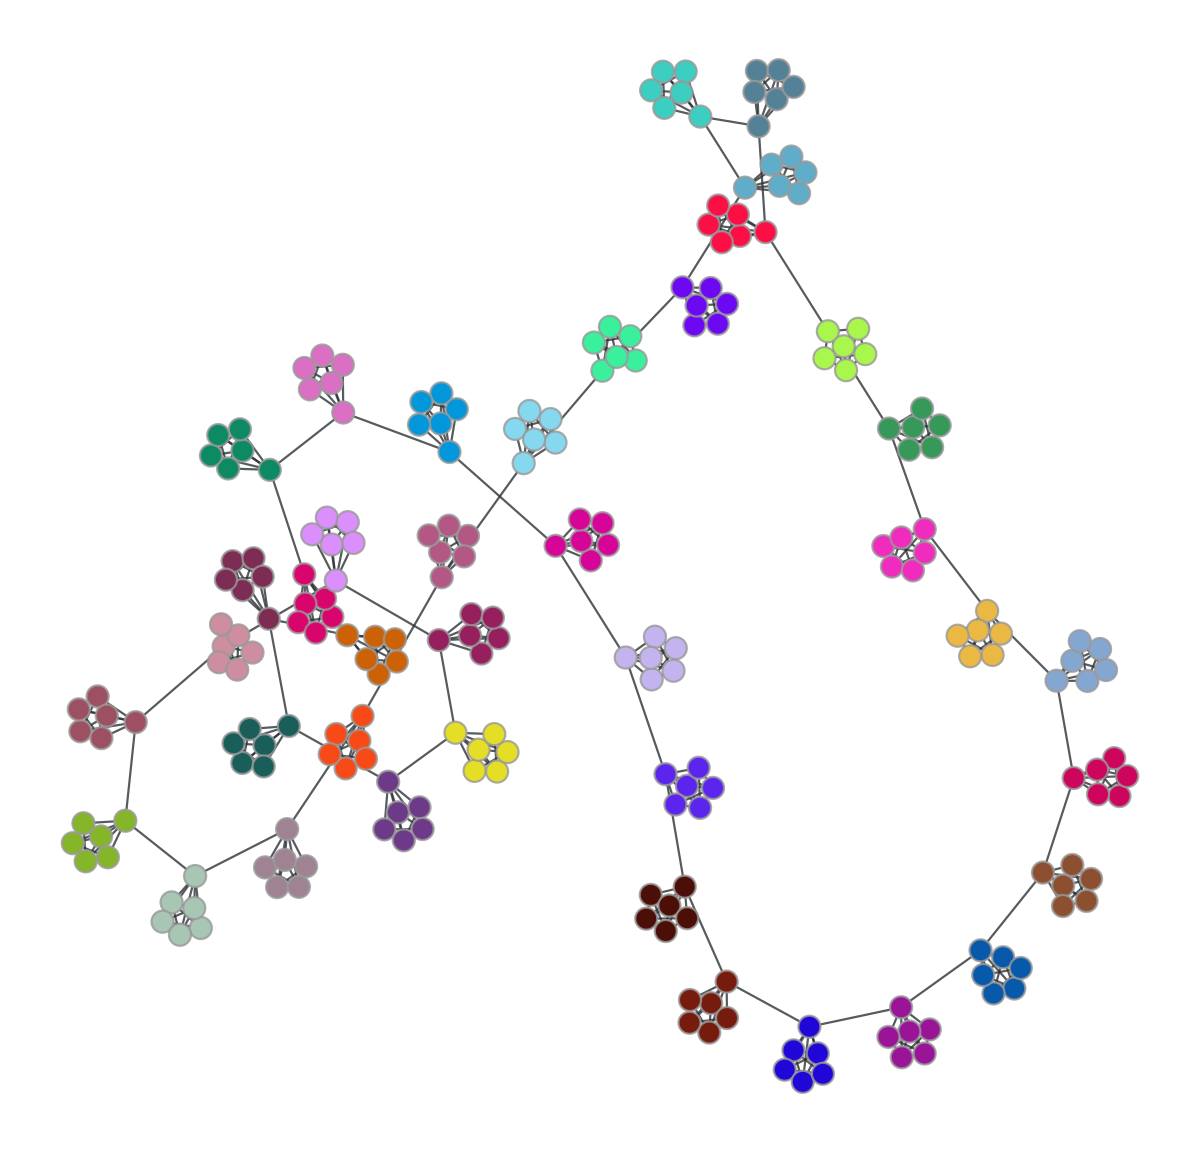

In [51]:
for vertex in graph.vertices():
    vertex_color_map[vertex] = "#808080"
cluster_id_to_color_dict = {}
for line in leiden_cpm_0_001_clustering_wcc.value[0].content.tobytes().decode("utf-8").strip().split("\n"):
    node_id,cluster_id = line.strip().split()
    if cluster_id not in cluster_id_to_color_dict:
        cluster_id_to_color_dict[cluster_id] = f"#{random.randint(0, 0xFFFFFF):06x}"
    vertex_color_map[old_to_new_id[node_id]] = cluster_id_to_color_dict[cluster_id]
new_pos = gt.graph_draw(graph, pos=pos, vertex_fill_color=vertex_color_map)

Do you notice anything different? One thing that will immediately stand out is the fact that each clique is labelled with a different color. This means that even though we started with an input clustering that had many cliques merged into a single cluster, simply processing it through WCC has put each clique into its own cluster.

## Chapter 3: Wrapping up
In this lesson, we achieved the following:
- Learn what a ring-of-cliques network is and visualize an example ring-of-cliques graph
- Use the GUI to cluster the network using Leiden-CPM algorithm with resolution value 0.001
- Get acquanted with the problem of resolution limit and visually see the impact it can have on a network clustering
- Use WCC to process a clustering facing resolution limit and improve the clusters